In [ ]:
using Revise, Distributed
addprocs(44);

In [ ]:
# ### Fitting a choice model
# Blah blah blah

using pulse_input_DDM

In [ ]:
using JLD2
JLD2.@load "mydata.jld2"

In [ ]:
# ### Geneerate some data
# Blah blah blah


#parameters of the latent model
#pz = Dict("generative" => vcat(1.,13.,-0.5,10.,1.,0.4,0.02), 
#    "name" => vcat("σ_i","B", "λ", "σ_a","σ_s","ϕ","τ_ϕ"),
#    "fit" => vcat(trues(7)),
#    "initial" => vcat(2.,15.,-5.,100.,2.,0.2,0.005),
#    "lb" => [eps(), 4., -5., eps(), eps(), eps(), eps()],
#    "ub" => [10., 100, 5., 800., 40., 2., 10.])

#parameters for the choice observation
#pd = Dict("generative" => vcat(0.1,0.1), 
#    "initial" => vcat(0.,0.5));

options = opt(lb=vcat([eps(), 4., -5., eps(), eps(), eps(), eps()],[-30,0.]),
    ub=vcat([10., 100, 5., 800., 40., 2., 10.],[30,1.]),
    x0=vcat([1.,13.,-0.5,50.,1.,0.4,0.01],[0.1,0.1]),
    fit=vcat(trues(9)))

In [ ]:
θ_syn = θchoice(θz=θz(σ2_i=1.,B=13.,λ=-0.5,σ2_a=50.,σ2_s=1.,ϕ=0.4,τ_ϕ=0.01), bias=0.1, lapse=0.1)
θ_syn, data = synthetic_data(;θ=θ_syn,ntrials=20000,rng=2)

# ### Optimize stuff
# Blah blah blah

model, options = optimize(data;options=options,iterations=80)

In [ ]:
gradient(model,options)

In [ ]:
# ### Compute Hessian
# Blah blah blah

H = Hessian(model)

In [ ]:
CI = CIs(model, H)

In [ ]:
model.θ.θz

In [ ]:
θ_syn = θchoice(θz=θz(σ2_i=1.,B=13.,λ=-0.5,σ2_a=50.,σ2_s=1.,ϕ=0.4,τ_ϕ=0.01), bias=0.1, lapse=0.1)
θ_syn, data = synthetic_data(;θ=θ_syn,ntrials=20000,rng=2)

# ### Optimize stuff
# Blah blah blah

model, options = optimize(data;options=options,iterations=80)

In [ ]:
# ### Compute Hessian
# Blah blah blah

H = Hessian(model)

In [ ]:
model = choiceDDM(θ,data)
pulse_input_DDM.gradient(model,53)

In [ ]:
# ### Get the CIs from the Hessian
# Blah blah blah

CI = CIs(model, H)

In [ ]:
using Flatten
using ForwardDiff

In [ ]:
@unpack θ, data = model
x = [Flatten.flatten(θ)...]
ℓℓ(x) = -loglikelihood(x, data, n)

In [ ]:
ForwardDiff.gradient(ℓℓ, x)


In [ ]:
eigvals(H)

In [ ]:
using PositiveFactorizations

In [ ]:
HPSD = Matrix(cholesky(Positive, H, Val{false}))

In [ ]:
eigvals(H)

In [ ]:
eigvals(HPSD)

In [ ]:
eigvecs(H)

In [ ]:
model.θ.θz

In [ ]:
model.θ.θz

In [ ]:
θ_syn.θz

In [ ]:
using JLD2
JLD2.@save "mydata2.jld2" data

In [ ]:
using JLD2
JLD2.@load "mydata2.jld2"

In [ ]:
data

In [ ]:
nT

In [ ]:
@unpack binned_clicks,choices = data

In [ ]:
using Parameters
@unpack clicks,nT,nL,nR,dt,centered = binned_clicks

In [ ]:
@unpack L,R,T,ntrials = clicks

In [ ]:
gradient(model,options)

In [ ]:
gradient(model,options)

In [ ]:
gradient(model,options)

In [ ]:
options

In [1]:
using pulse_input_DDM
using PyPlot
using Parameters

┌ Info: Precompiling pulse_input_DDM [c2542da2-1f7d-11e9-2506-87691095ebb2]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **



In [9]:
θ, data = synthetic_data(ntrials = 5000)

(θchoice{θz{Float64},Float64}
  θz: θz{Float64}
  bias: Float64 0.0
  lapse: Float64 0.01
, choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}[choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}
  click_data: pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}
  choice: Bool false
  sessbnd: Bool false
, choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}
  click_data: pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}
  choice: Bool true
  sessbnd: Bool false
, choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}
  click_data: pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}
  choice: Bool false
  sessbnd: Bool false
, choicedata{pulse_input_DDM.choiceinputs{pulse_input_DDM.clicks,pulse_input_DDM.binned_clicks}}
  click_

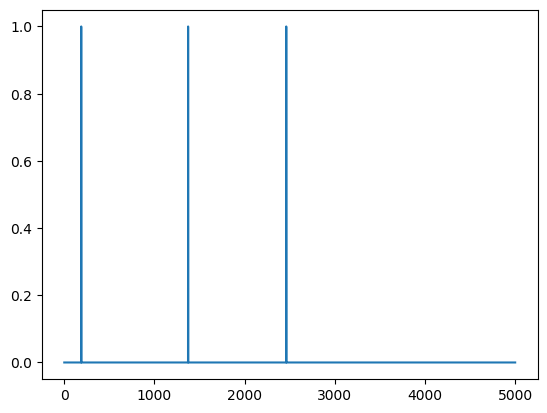

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14d1bc310>

In [10]:
sessbnd = map(data->data.sessbnd,data)
plot(sessbnd)

In [23]:
a,b = filter(x -> x == 1, sessbnd)


true

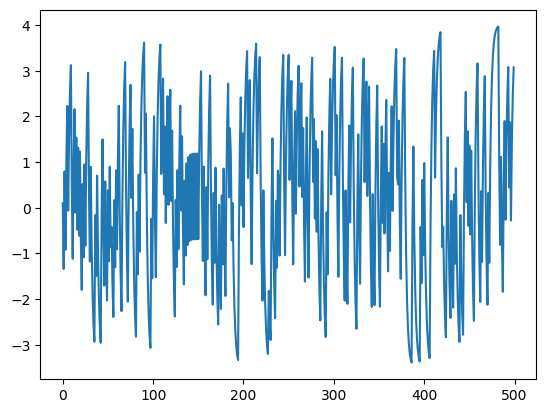

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14f3013d0>

In [14]:
@unpack ibias, eta, beta = θ.θz
clickdata = map(data->data.click_data,data)
sessbnd = map(data->data.sessbnd,data)

i_0 = pulse_input_DDM.compute_initial_pt(ibias,eta,beta,clickdata, sessbnd)
plot(i_0[1:500])

In [15]:
ibias


0.1

In [3]:
n = 53;
options = choiceoptions(fit = vcat(false,true, true, true, true, true, true, true, true, true, false, false),
    lb = vcat([0.,-2., -4.,-0.9, .5, -5., 0., 0., 0.01, 0.005], [-30, 0.]),
    ub = vcat([eps(),2., 4., 0.9, 30., 5., 100., 2.5, 1.2, 1.], [30, 1.]),
    x0 = vcat([eps(),0.5, 0.9, 0.6, 15., -0.5, 2., 1.5, 0.8, 0.05], [0.,1e-5]))


choiceoptions
  fit: Array{Bool}((12,)) Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
  lb: Array{Float64}((12,)) [0.0, -2.0, -4.0, -0.9, 0.5, -5.0, 0.0, 0.0, 0.01, 0.005, -30.0, 0.0]
  ub: Array{Float64}((12,)) [2.220446049250313e-16, 2.0, 4.0, 0.9, 30.0, 5.0, 100.0, 2.5, 1.2, 1.0, 30.0, 1.0]
  x0: Array{Float64}((12,)) [2.220446049250313e-16, 0.5, 0.9, 0.6, 15.0, -0.5, 2.0, 1.5, 0.8, 0.05, 0.0, 1.0e-5]


In [6]:
model, = optimize(data, options, n; iterations=5, outer_iterations=1)


Fminbox
-------
Initial mu = 0.00202187

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.00202187

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     2.498143e+01     4.865063e+01
 * time: 3.695487976074219e-5
     1     2.381048e+01     4.195304e+01
 * time: 2.451663017272949
     2     2.314796e+01     5.225496e+01
 * time: 4.798779010772705


InterruptException: InterruptException:

In [ ]:
@unpack ibias, eta, beta = θ.θz
clickdata = map(data->data.click_data,data)
i_0 = pulse_input_DDM.compute_initial_pt(0.,eta,beta,clickdata)

In [ ]:
plot(i_0)

In [ ]:
θ, data = synthetic_data(ntrials = 500)
ll = loglikelihood(θ, data,n)

In [ ]:
 # not respecting session boundaries yet
ΔLR = pulse_input_DDM.diffLR.(clickdata)
correct = map(ΔLR->sign(ΔLR),ΔLR)